In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns

# Seleccion de agentes 2vs0

In [3]:
def get_data_folder(base_path):
    pat = ["figure", "video", "pyt_save", "jpg"]
    not_in = lambda x: all([not pat_l.lower() in x for pat_l in pat])
    agents_statistics = pd.DataFrame(columns=['path',"success_rate", "mean_steps", "std_steps", "std_meanvel_p0", "std_meanvel_p1", "pass_average"])
    agents_statistics_list = []
    progress = []
    run_progress = []
    model_names = []
    pass_average = []

    for exp in os.listdir(base_path):
        dir_path = f"{base_path}\\{exp}"
        if os.path.isdir(dir_path) and not_in(dir_path.split("\\")[-1]):
            exp_dir = os.listdir(dir_path)[0]
            the_path = f"{dir_path}\\{exp_dir}\\pyt_save\\"
            folder_list = os.listdir(the_path)
            folder_list.sort()
            for directory in folder_list:
                dir_path2 = f"{the_path}\\{directory}"
                the_path2 = f"{dir_path2}\\progress.txt"

                if directory[-4:] != "test":
                    run_progress = pd.read_csv(os.path.join(the_path2), delimiter="\t")


                    #get succes rate: 
                    successful_games = np.where(run_progress["success"])[0]
                    successful_game_count = np.sum(run_progress["success"])
                    success_rate = successful_game_count/run_progress.shape[0]
                    
                    if success_rate>0.9:
                        # get mean steps and std:
                        mean_steps = np.mean(run_progress["steps"])
                        std_steps = np.std(run_progress["steps"])

                        # get speed variance: 
                        std_meanvel_p0 = np.std(run_progress["Averagevel_player_0"])
                        std_meanvel_p1 = np.std(run_progress["Averagevel_player_1"])

                        value_dict.update({"path": the_path2,
                                    "success_rate": success_rate,
                                    "mean_steps": mean_steps,
                                    "std_steps": std_steps,
                                    "std_meanvel_p0": std_meanvel_p0,
                                    "std_meanvel_p1": std_meanvel_p1})
                        agents_statistics_list.append(value_dict)
                        
                else: 
                    run_res = pd.read_csv(the_path2, delimiter="\t")
                    columns = run_res.columns
                    value_dict = {"pass_average": np.sum(run_res["received_pass_0"]+run_res["received_pass_1"])/np.sum(run_res["done"])}

    agents_statistics_list = [pd.DataFrame([val]) for val in agents_statistics_list]
    if len(agents_statistics_list)>0:
        agents_statistics = pd.concat(agents_statistics_list, ignore_index=True)                  
        agents_statistics.set_index("path", inplace=True)
    return agents_statistics

In [5]:
base_path ="D:\\rl_soccer\\2vs0\\junio_test_2022\\"
experiments = os.listdir(base_path)

is_dir = lambda x: os.path.isdir(os.path.join(base_path, x))
experiments =  filter(is_dir, experiments)
statistics_results = []
for a_experiment in experiments:
    
    experiment_path = os.path.join(base_path, a_experiment)
    statistics_results.append(get_data_folder(experiment_path))

    

C:\Users\rocho\AppData\Local\Temp\ipykernel_15356\3159397699.py:49: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  run_res = pd.read_csv(the_path2, delimiter="\t")
C:\Users\rocho\AppData\Local\Temp\ipykernel_15356\3159397699.py:49: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  run_res = pd.read_csv(the_path2, delimiter="\t")
C:\Users\rocho\AppData\Local\Temp\ipykernel_15356\3159397699.py:49: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  run_res = pd.read_csv(the_path2, delimiter="\t")


In [ ]:
len(statistics_results)

7

# Plotting section

In [6]:
def generate_plot_stastistics(statistic_result):
    dictionary_list = []
    for an_experiment in statistic_result:
        if len(an_experiment["pass_average"])>0:
            result_dictionary = {}
            result_dictionary["pass_average"] = an_experiment["pass_average"].tolist()
            mean_steps = (an_experiment["mean_steps"].astype(float))
            result_dictionary["sizes"] = mean_steps.tolist()
            result_dictionary["N_sizes"] = 100*(mean_steps-np.min(mean_steps))/(np.max(mean_steps)-np.min(mean_steps))
            result_dictionary["sumed_velocity"] = (an_experiment["std_meanvel_p0"]+ an_experiment["std_meanvel_p1"]).tolist()
            result_dictionary["success_rate"] = an_experiment["success_rate"].tolist()
            dictionary_list.append(result_dictionary)
    return dictionary_list

result_list = generate_plot_stastistics(statistics_results)

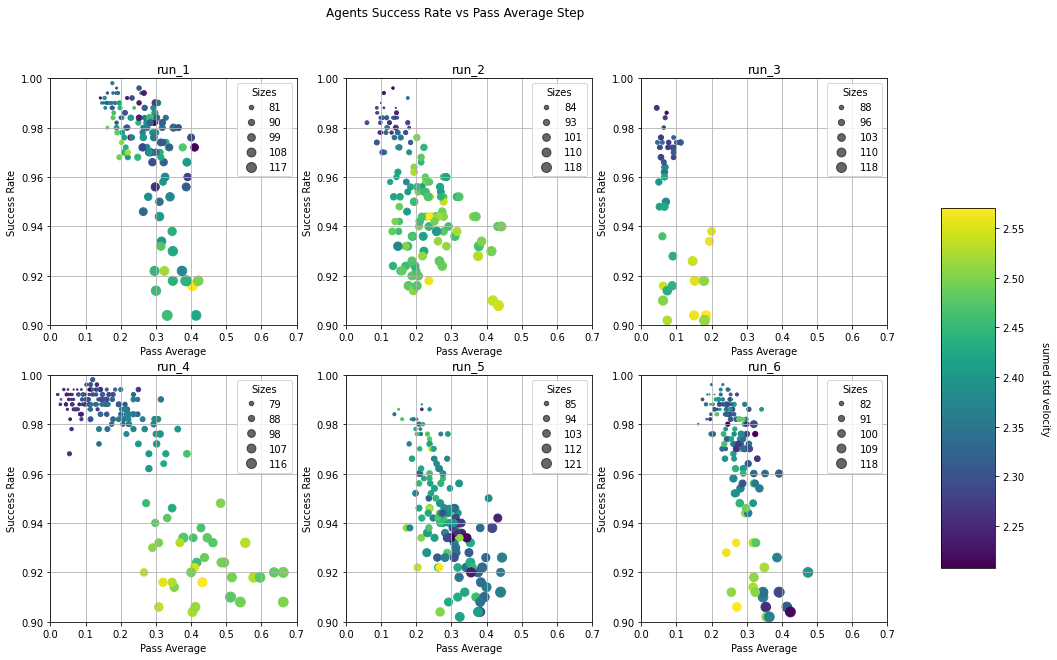

In [38]:
from itertools import chain
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, result in enumerate(result_list):
    i_real = i
    i, j = int(i>2), int(i%3)    
    a = ax[i, j].scatter(result["pass_average"],  result["success_rate"], c=result["sumed_velocity"], s=result["N_sizes"])
    handles, labels = a.legend_elements(prop="sizes", alpha=0.6, num=5)
    labels = [int((np.max(result["sizes"])-np.min(result["sizes"]))*int("".join(x for x in label if x.isdigit()))/100+ np.min(result["sizes"])) for label in labels]
    ax[i,j].legend(handles, labels, title="Sizes")
    ax[i,j].set_xlabel("Pass Average")
    ax[i,j].set_ylabel("Success Rate")
    ax[i,j].set_title(f"run_{i_real+1}")
    ax[i,j].set_xlim(0, 0.7)
    ax[i, j].set_ylim(0.9, 1)
    ax[i,j].grid()


cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.5])

vel_color = fig.colorbar(a, cax=cbar_ax)
vel_color.set_label("sumed std velocity", rotation=270, labelpad=25)
fig.suptitle("Agents Success Rate vs Pass Average Step")    
#plt.show()
plt.savefig(os.path.join(base_path,"all.jpg"), bbox_inches='tight')

In [29]:
labels
print(int(np.max(mean_steps)), int(np.min(mean_steps)))

118 75


In [30]:
[int(''.join(char for char in label if char.isdigit())) for label in labels]

[25, 50, 75, 100]

In [87]:
agents_statistics_selected = agents_statistics[((agents_statistics["pass_average"]>=0.1) & (agents_statistics["success_rate"]>0.96))]

In [88]:
run_progress.head()

,steps,success,pitch_size,Averagevel_player_0,Stdvel_player_0,Averagevel_player_1,Stdvel_player_1
0,78,1,"(22.05804142937511, 16.54353107203133)",0.706533,0.817798,3.641716,2.701948
1,122,1,"(23.197631955152627, 17.39822396636447)",0.429182,0.882430,2.844959,2.058391
2,79,1,"(22.507448676570363, 16.880586507427772)",1.679201,1.545492,3.123651,2.101945
3,51,1,"(20.925073588598263, 15.693805191448696)",1.228916,0.724607,2.654325,1.177220
4,94,1,"(20.80168423322455, 15.60126317491841)",2.123915,1.421328,4.010804,1.858693


In [89]:
import re
experiment_path = lambda x: "\\".join(x.split('\\')[:-2]).replace(base_path, "")
model_detector = lambda x: re.search('(?<=model)[0-9]*', x).group(0)



In [14]:
model_detector(agents_statistics_selected.index[0])

'2369999'

In [15]:
models = list(map(model_detector, agents_statistics_selected.index))
path_orig = list(map(experiment_path, agents_statistics_selected.index))

In [16]:
matrix = np.concatenate([np.array(path_orig)[..., None], np.array(models)[..., None]], -1)

In [17]:
model_df = pd.DataFrame(matrix,columns=["model_path", "model_name"])

In [18]:
model_df.head()

,model_path,model_name
0,\2022-07-04_02-44-34_\2022-06-08_23-03-58_td3_...,2369999
1,\2022-07-03_09-13-01_\2022-06-08_23-03-58_td3_...,2459999
2,\2022-07-03_02-18-40_\2022-06-08_23-03-58_td3_...,2219999
3,\2022-07-04_04-58-46_\2022-06-08_23-03-58_td3_...,2489999
4,\2022-07-02_19-11-33_\2022-06-08_23-03-58_td3_...,2899999


In [19]:
model_df.to_csv(os.path.join(base_path,"selected_models.csv"), sep="\t")

In [65]:
with open("models.txt", "w") as f:
    for model in models:
        f.write(model)
        f.write("\n")
        


In [66]:
with open("origen_path.txt", "w") as f:
    for model in path_orig:
        f.write(model)
        f.write("\n")

In [67]:
import os.path as osp
with open("D:\\rl_soccer\\results\\resultados\\T1_2vs0_final\\agents_2vs_2T1.py", "w") as f:
    f.write("Teams = [\n")
    for i in model_df.index:
        row = model_df.iloc[i]
        path = row.model_path.encode('utf-8').decode()
        model_name = row.model_name
        f.write(f"('{path}', {model_name}),\n")
    f.write("\n]")

experiment_path(agents_statistics_selected.index[0])

In [68]:
osp.normpath(model_df.iloc[0].model_path)

'\\2022-06-21_22-28-41_\\2022-06-08_23-05-26_td3_soccer_goal_orig_concat_2vs0_0.1\\pyt_save'

In [69]:
model_df.iloc[0].model_path

'\\2022-06-21_22-28-41_\\2022-06-08_23-05-26_td3_soccer_goal_orig_concat_2vs0_0.1\\pyt_save\\'

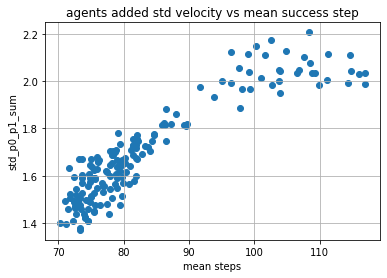

In [70]:
plt.scatter(agents_statistics["mean_steps"], agents_statistics["std_meanvel_p0"]+agents_statistics["std_meanvel_p1"])
plt.plot()
plt.title("agents added std velocity vs mean success step")
plt.ylabel("std_p0_p1_sum")
plt.xlabel("mean steps")
plt.grid()
plt.show()

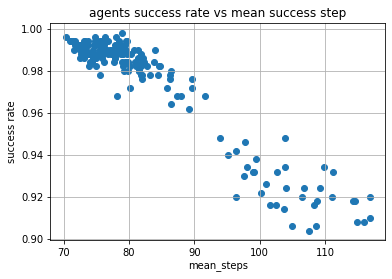

In [71]:
plt.scatter(agents_statistics["mean_steps"], agents_statistics["success_rate"])
plt.plot()
plt.title("agents success rate vs mean success step")
plt.xlabel("mean_steps")
plt.ylabel("success rate")
plt.grid()
plt.show()

In [72]:
agents_statistics_selected = agents_statistics[agents_statistics["mean_steps"]<67]

In [73]:
run_progress.head()

,steps,success,pitch_size,Averagevel_player_0,Stdvel_player_0,Averagevel_player_1,Stdvel_player_1
0,78,1,"(22.05804142937511, 16.54353107203133)",0.706533,0.817798,3.641716,2.701948
1,122,1,"(23.197631955152627, 17.39822396636447)",0.429182,0.882430,2.844959,2.058391
2,79,1,"(22.507448676570363, 16.880586507427772)",1.679201,1.545492,3.123651,2.101945
3,51,1,"(20.925073588598263, 15.693805191448696)",1.228916,0.724607,2.654325,1.177220
4,94,1,"(20.80168423322455, 15.60126317491841)",2.123915,1.421328,4.010804,1.858693


In [74]:
import re
experiment_path = lambda x: "\\".join(x.split('\\')[:-2]).replace(base_path, "")
model_detector = lambda x: re.search('(?<=_model)[0-9]*', x).group(0)



In [75]:
model_detector(agents_statistics_selected.index[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
models = list(map(model_detector, agents_statistics_selected.index))
path_orig = list(map(experiment_path, agents_statistics_selected.index))

In [ ]:
agents_statistics_selected.index


Index(['D:\rl_soccer\results\resultados\T1_2vs0_final\2022-01-07_00-03-58_td3_soccer_goal_pass_join_2vs0_01_07_2022_00_03_58\test_results\2022-01-21_02-23-31_model2889999.pt_test_run',
       'D:\rl_soccer\results\resultados\T1_2vs0_final\2022-01-07_00-03-58_td3_soccer_goal_pass_join_2vs0_01_07_2022_00_03_58\test_results\2022-01-21_02-56-35_model2989999.pt_test_run',
       'D:\rl_soccer\results\resultados\T1_2vs0_final\2022-01-07_00-03-58_td3_soccer_goal_pass_join_2vs0_01_07_2022_00_03_58\test_results\2022-01-21_04-09-33_model2579999.pt_test_run',
       'D:\rl_soccer\results\resultados\T1_2vs0_final\2022-01-07_00-03-58_td3_soccer_goal_pass_join_2vs0_01_07_2022_00_03_58\test_results\2022-01-21_08-03-37_model2799999.pt_test_run',
       'D:\rl_soccer\results\resultados\T1_2vs0_final\2022-01-07_00-03-58_td3_soccer_goal_pass_join_2vs0_01_07_2022_00_03_58\test_results\2022-01-21_10-08-13_model2319999.pt_test_run',
       'D:\rl_soccer\results\resultados\T1_2vs0_final\2022-01-07_00-03-58_t

In [ ]:
matrix = np.concatenate([np.array(path_orig)[..., None], np.array(models)[..., None]], -1)

In [ ]:
model_df = pd.DataFrame(matrix,columns=["model_path", "model_name"])

In [ ]:
model_df.head()

,model_path,model_name
0,2022-01-07_00-03-58_td3_soccer_goal_pass_join_...,2889999
1,2022-01-07_00-03-58_td3_soccer_goal_pass_join_...,2989999
2,2022-01-07_00-03-58_td3_soccer_goal_pass_join_...,2579999
3,2022-01-07_00-03-58_td3_soccer_goal_pass_join_...,2799999
4,2022-01-07_00-03-58_td3_soccer_goal_pass_join_...,2319999


In [ ]:
model_df.to_csv(os.path.join(base_path,"selected_models.csv"))

In [ ]:
with open("models.txt", "w") as f:
    for model in models:
        f.write(model)
        f.write("\n")
        


In [ ]:
with open("origen_path.txt", "w") as f:
    for model in path_orig:
        f.write(model)
        f.write("\n")

In [ ]:
import os.path as osp
with open("D:\\rl_soccer\\results\\resultados\\T1_2vs0_final\\agents_2vs_2T1.py", "w") as f:
    f.write("Teams = [\n")
    for i in model_df.index:
        row = model_df.iloc[i]
        path = row.model_path.encode('utf-8').decode()
        model_name = row.model_name
        f.write(f"('{path}', {model_name}),\n")
    f.write("\n]")

experiment_path(agents_statistics_selected.index[0])

In [ ]:
osp.normpath(model_df.iloc[0].model_path)

In [ ]:
model_df.iloc[0].model_path